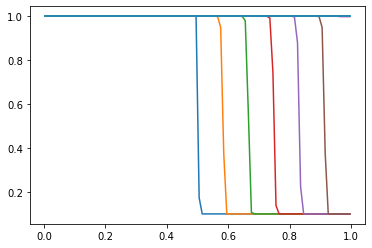

In [2]:
# Burgers eq.
# Reference:
# https://physics.princeton.edu//~fpretori/Burgers/Code.html
    
# Grid parameters
Nx = 100
Ng = 3
xmin = 0.0
xmax = 1.0
dx = (xmax - xmin)/Nx
x = np.arange(xmin + 0.5*dx, xmax + 0.5*dx, dx)

# init fluid
q_L = 1.0
q_R = 0.1
q = np.where(x < 0.5*(xmin + xmax), q_L, q_R)

# minmod function
def minmod(a, b):
    
    return np.where(a*b < 0.0, np.where(np.abs(a) < np.abs(b), a, b))

# Jacobian matrix at x
def calc_A(q):
    A = q
    return A

# eigenvectors of Jacobian
def calc_eta(A):
    eta = 1.0
    return eta

def calc_lamb(A):
    lamb = A
    return lamb

def calc_omega(qL, qR, eta):
    omega = qR - qL
    return omega

def calc_FF(fR, fL, lamb, eta, omega):
    FF = 0.5*(fR + fL - lamb*eta*omega)
    return FF

def calc_f(q):
    f = 0.5*q*q
    return f

def dqL_1(dq_imh, dq_iph):
    return minmod(dq_imh, dq_iph)

def dqR_1(dq_iph, dq_ip3h):
    return minmod(dq_iph, dq_ip3h)

def dqL_2(dq_imh, dq_iph):
    theta = dq_imh/dq_iph
    return np.where(np.abs(dq_iph) <= 1e-6, 0.0,
                    np.maximum(np.maximum(0.0, np.minimum(1.0,2*theta)), np.minimum(2.0, theta))*dq_iph)

def dqR_2(dq_iph, dq_ip3h):
    theta = dq_ip3h/dq_iph
    return np.where(np.abs(dq_iph) <= 1e-6, 0.0,
                    np.maximum(np.maximum(0.0, np.minimum(1.0,2*theta)), np.minimum(2.0, theta))*dq_iph)

def dqL_3(dq_imh, dq_iph):
    theta = dq_imh/dq_iph
    return np.where(np.abs(dq_iph) <= 1e-6, 0.0,
                    np.maximum(0.0, np.minimum(np.minimum(0.5*(1.0+theta),2.0), 2.0*theta))*dq_iph)

def dqL_3(dq_iph, dq_ip3h):
    theta = dq_ip3h/dq_iph
    return np.where(np.abs(dq_iph) <= 1e-6, 0.0,
                    np.maximum(0.0, np.minimum(np.minimum(0.5*(1.0+theta),2.0), 2.0*theta))*dq_iph)

# reconstructs primitive variable q from the left
def reconst_qL(q_im1,q_i,q_ip1,r_im1,r_i,r_ip1):
    dq_iph = q_ip1 - q_i
    dq_imh = q_i - q_im1
    dq_i = dqL_2(dq_imh, dq_iph)
    rqL_iph = q_i + dq_i*0.5
    return rqL_iph


def reconst_qR(q_i,q_ip1,q_ip2,r_i,r_ip1,r_ip2):
    dq_iph = q_ip1 - q_i
    dq_ip3h = q_ip2 - q_ip1
    dq_i = dqR_2(dq_iph, dq_ip3h)
    rqR_iph = q_ip1 + dq_i*0.5
    return rqR_iph

def calc_flux(q, x, Nx, Ng):
    rqL_iph = np.zeros_like(x)
    rqR_iph = np.zeros_like(x)

    rqL_iph[Ng-1:Nx-Ng+1] = reconst_qL(q[Ng-2:Nx-Ng], q[Ng-1:Nx-Ng+1], q[Ng:Nx-Ng+2],
                                     x[Ng-2:Nx-Ng], x[Ng-1:Nx-Ng+1], x[Ng:Nx-Ng+2])
    rqR_iph[Ng-1:Nx-Ng+1] = reconst_qR(q[Ng-1:Nx-Ng+1], q[Ng:Nx-Ng+2], q[Ng+1:Nx-Ng+3],
                                       x[Ng-1:Nx-Ng+1], x[Ng:Nx-Ng+2], x[Ng+1:Nx-Ng+3])
    
    rq_iph = 0.5*(rqL_iph + rqR_iph)
    A = calc_A(rq_iph)
    eta = calc_eta(A)
    lamb = calc_lamb(A)
    omega = calc_omega(rqL_iph, rqR_iph, eta)
    fR_iph = calc_f(rqR_iph)
    fL_iph = calc_f(rqL_iph)
    FF_iph = calc_FF(fR_iph, fL_iph, eta, lamb, omega)
    FF = FF_iph
    return FF

def update_q(qn, x, FF, dt, Nx, Ng):
    dx = x[1] - x[0]
    qnp1 = np.zeros(Nx)
    qnp1[Ng:Nx-Ng] = qn[Ng:Nx-Ng] - dt/dx*(FF[Ng:Nx-Ng]-FF[Ng-1:Nx-Ng-1])
    # constant extrapolation
    qnp1[0:Ng] = qnp1[Ng]
    qnp1[Nx-Ng:] = qnp1[Nx-Ng-1]
    
    return qnp1

# Moving forward one time step
def step(q, dt):
    FF = calc_flux(q, x, Nx, Ng)
    q_nph = update_q(q, x, FF, 0.5*dt, Nx, Ng)
    FF = calc_flux(q_nph, x, Nx, Ng)
    q_np1 = update_q(q_nph, x, FF, dt, Nx, Ng)
    
    return q_np1

t = 0.0
t_plt = 0.0
tmax = 1
dt = 0.001
dt_plt = 0.1
while t < tmax:
    q_np1 = step(q, dt)
    t += dt
    if t >= t_plt:
        plt.plot(x, q_np1)
        t_plt += dt_plt
    q = q_np1